# Team Quious Qubits - Qiskit Challenge India

### Teammates:
* Nishal Kulkarni 
* Aakash Shinde
* Saurabh Singh Bajeli
* Arnob Sarkar
* Kishore Kumar

#### Final Submission Notebook:
* Accuracy: 0.815
* Circuit cost: 195 

In [1]:
# we have imported a few libraries we think might be useful 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer

from qiskit import *
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram
%matplotlib inline
import matplotlib.pyplot as plt

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA


# The the write_and_run() magic function creates a file with the content inside the cell that it is run. 
# You have used this in previous exercises for creating your submission files. 
# It will be used for the same purpose here.

from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

## Choosing the right training data!

In [2]:
# importing the dataset provided
data_path='./dataset/'
data = np.loadtxt(data_path + "challenge_dataset_4_9_dim3_training.csv", delimiter=",")

# extracting the first column which contains the labels
data_labels = data[:, :1].reshape(data.shape[0],)
# extracting all the columns but the first which are our features
data_features = data[:, 1:]

During the first day we used first 20 data points for both *4* and *9*, after messing around with the feature map and variational circuit we still weren't able to get a good score so naturally we decided to tinker with the training inputs for a bit.

Increasing the training input size(*train_size*) was the obvious first modification we made and it did give us better results. Still this alone wasn't enough, the next thing we did was take random inputs from the dataset and this was our double edged sword it helped us in getting the initial high score of 0.813 but at the same time we got really bad results using the same circuit but a different subset of the main dataset.

We needed to make sure the the training inputs accurately represented the fours and the nines. We ensured this by running same circuits using different random datapoints.

**Note**: We increased the train_size upto 2000 (1000 fours and 1000 nines) so that we could somehow squeeze out a minor increase in our final score. While it did give us a 0.01 boost (0.80X to 0.815) it took considerable amount of time(hours) with our personal computers screaming for help.😂

In [3]:
### WRITE YOUR CODE BETWEEN THESE LINES - START

# do your classical pre-processing here
train_size = 500
test_size = 200

divide = 3020

number_of_rows = data_features.shape[0]
random_indices = np.random.choice(3000, size=train_size//2, replace=False)

four_train = data_features[random_indices,:]
nine_train = data_features[random_indices+3000,:]


four_test = data_features[train_size + 1:train_size + test_size + 1]
nine_test = data_features[divide+train_size + 1:divide+train_size + test_size + 1]

training_input = {'A':four_train, 'B':nine_train}
testing_input = {'A':four_test, 'B':nine_test}

### WRITE YOUR CODE BETWEEN THESE LINES - END

## Custom Feature Map

We tried different inbuilt data encoding circuits, like the ZFeatureMap, ZZFeatureMap and the PauliFeatureMap our initial high score of(0.813) was because of using a PauliFeatureMap with **'ZX','XY','YZ'** as the paulis [the circuit cost was very high(above 300)]. Although we got a good score, on testing with different datapoints our score wasn't anywhere near the online score.

Even after trying out several different paulis we were stuck with no progress for a day or two, we finally decided that sticking to inbuilt circuits is not helping so we created our own feature map and variational circuit.

Building our own circuits was hard because we had no idea what makes one circuit better from another, we also went through research papers but to no avail.

We started out by replicating inbuilt ZZFeatureMap and then individually adding and removing gates, this entire process was a guessing game along with trial and error, while this didn't help us with improving our score, it provided us with a way of obtaining consistent results and helped us notice patterns by slightly modifying our circuit. 

One thing which helped us was taking ample notes of the results while messing around with the feature map. Applying a similar process to the variational circuit gave us the boost we wanted.

We don't have a concrete idea as to which one particular gate (or set of gates) helped or hindered the probability, but a general methodology we followed was if any additional gate decreased our score by more the 0.03 we removed it and this way noted down how all the gates impacted our score. In the final circuit we only included the gates which helped us achieve the maximum possible score without changing the variational circuit.

In [4]:
%%write_and_run feature_map.py
# the write_and_run function writes the content in this cell into the file "feature_map.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def feature_map(): 
    # BUILD FEATURE MAP HERE - START
    num_qubits = 3            
    reps = 1
    x = ParameterVector('theta', length=(num_qubits))
    feature_map = QuantumCircuit(num_qubits)
    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.ry((np.pi+x[i])*(np.pi+x[i]), i)
            feature_map.h(i)
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                feature_map.cx(i, j)
                feature_map.ry((np.pi-x[j])*(np.pi-x[i]),j)
                feature_map.cx(i, j)
    for i in range(num_qubits):
            feature_map.h(i)
            feature_map.rx((np.pi-x[i])*(np.pi+x[i]), i)
            feature_map.rz((np.pi-x[i])*(np.pi+x[i]), i)

    # BUILD FEATURE MAP HERE - END
    
    #return the feature map which is either a FeatureMap or QuantumCircuit object
    return feature_map

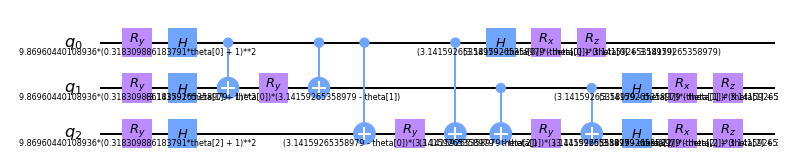

In [5]:
feature_map().draw()

## Custom variational circuit
We started out testing different inbuilt N-local circuits like Real Amplitude and EfficientSU2 circuit.

Like the feature map we weren't able to progress in the contest by only using inbuilt circuits, we tried increasing the number of repetitions(reps) or changing the entanglement from "full" to "linear", none of them helped us and infact had a negative impact on our score. So we moved on to building a custom variational circuits.

We initially tried out all the circuits given in paper[1] none of them gave us really good results, we think this might mostly be because of us hastily testing and discarding each and every circuit without extensively testing what impact each circuit had. 

The final variational circuit we settled for was identical to the inbuilt EfficientSU2 circuit except for a **X gate** placed on the first qubit in each repetition after all the CNOT gates.

We chose **X gate** in particular was because we had been noting down how adding or removing a single gate at a time impacted our final score, Y and Z gates didn't really help improve our score and H gate had a negative impact.

This was our **Aha! moment** we were finally able to achieve consistent score of 0.79 to 0.81 and the cost of our circuit was less than 200!

[1] [Expressibility and entangling capability of parameterized quantum circuits for hybridquantum-classical algorithms](https://arxiv.org/pdf/1905.10876.pdf)

In [6]:
%%write_and_run variational_circuit.py
# the write_and_run function writes the content in this cell into the file "variational_circuit.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def variational_circuit():
    # BUILD VARIATIONAL CIRCUIT HERE - START
    num_qubits = 3            
    reps = 3
    x = ParameterVector('L', length=(num_qubits*(reps+1)*(reps+1)))
    var_circuit = QuantumCircuit(num_qubits)
    count = 0
    for _ in range(reps):
        for i in range(num_qubits):
            var_circuit.ry(x[count], i)
            count+=1
        for i in range(num_qubits):
            var_circuit.rz(x[count], i)
            count+=1
        for i in range(num_qubits):
            for j in range(i+1,num_qubits):
                var_circuit.cx(i,j)
        var_circuit.x(0)
 
    for i in range(num_qubits):
        var_circuit.ry(x[count], i)
        count+=1
    for i in range(num_qubits):
        var_circuit.rz(x[count], i)
        count+=1
    # BUILD VARIATIONAL CIRCUIT HERE - END
    
    # return the variational circuit which is either a VaritionalForm or QuantumCircuit object
    return var_circuit

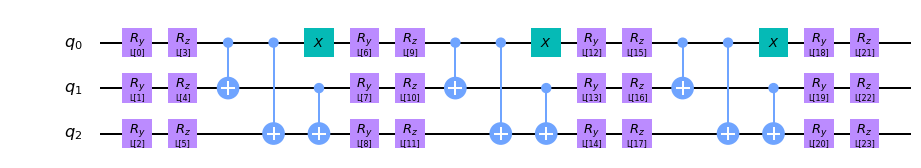

In [7]:
variational_circuit().draw()

## Classical Optimizer
We tried out different optimizers like COBYLA, ADAM [Which for some reason gave us poor results] and many other inbuilt optimizers, finally settling for NFT.

The reason we chose NFT is because while going through paper ${[1]}$ which demonstrated using numerical simulations that this method converges to a better solution much faster than the existing ones, especially in the presence of a large statistical error. 

For the maxfev parameter, which is the maximum number of function evaluations to perform, we set it to 100 as it gave us good *optimal parameters* in a timely manner.

[1] [Sequential minimal optimization for quantum-classical hybrid algorithms](https://arxiv.org/pdf/1903.12166)

In [8]:
def classical_optimizer():
    # CHOOSE AND RETURN CLASSICAL OPTIMIZER OBJECT - START
    
    # import the required clasical optimizer from qiskit.aqua.optimizers
    from qiskit.aqua.components.optimizers import NFT
    # creating an optimizer object
    cls_opt = NFT(maxfev=100)
    # CHOOSE AND RETURN CLASSICAL OPTIMIZER OBJECT - END
    return cls_opt

The below 4 cells we used as is to get the optimal parameters.

In [9]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

In [10]:
# a fixed seed so that we get the same answer when the same input is given. 
seed = 10598

# setting our backend to qasm_simulator with the "statevector" method on. This particular setup is given as it was 
# found to perform better than most. Feel free to play around with different backend options.
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance using the backend and backend options taken before
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, 
                                   backend_options=backend_options)

# creating a VQC instance which you will be used for training. Make sure you input the correct training_dataset and 
# testing_dataset as defined in your program.
vqc = VQC(optimizer=classical_optimizer(), 
          feature_map=feature_map(), 
          var_form=variational_circuit(), 
          callback=call_back_vqc, 
          training_dataset=training_input,     # training_input must be initialized with your training dataset
          test_dataset=testing_input)             # testing_input must be initialized with your testing dataset

In [ ]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)

print("testing success ratio: {}".format(result['testing_accuracy']))

In [ ]:
print(repr(vqc.optimal_params))

We copied the optimal parameters output by the classifier and pasted it below, again without any modifications.

In [11]:
%%write_and_run optimal_params.py
# # the write_and_run function writes the content in this cell into the file "optimal_params.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
import numpy as np
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def return_optimal_params():
    # STORE THE OPTIMAL PARAMETERS AS AN ARRAY IN THE VARIABLE optimal_parameters 
    optimal_parameters = [ 1.16370687,  4.46168562, -0.08423645,  1.72169836, -1.97944324,
        0.76741261,  3.3961714 , -0.08275362,  0.99361498, -1.25034409,
        1.31740853, -1.19064513,  0.8859624 , -0.75398297, -0.3870601 ,
        1.57664325, -0.59876139, -0.68596938,  0.56001643,  0.39367396,
       -0.37378898,  0.09231426, -1.0872162 ,  1.06101273]
    # STORE THE OPTIMAL PARAMETERS AS AN ARRAY IN THE VARIABLE optimal_parameters 
    return np.array(optimal_parameters)

The final compiled code is output to  finalanswer.py file

In [12]:
solution = ['feature_map.py','variational_circuit.py','optimal_params.py']
file = open("finalanswer.py","w")
file.truncate(0)
for i in solution:    
    with open(i) as f:
        with open("finalanswer.py", "a") as f1:
            for line in f:
                f1.write(line)
file.close()

Below 2 cells provide us with the offline grader, we have made no modifications here. 

In [13]:
#imports required for the grading function 
from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit.aqua.components.variational_forms import VariationalForm
import numpy as np

In [14]:
def grade(test_data, test_labels, feature_map, variational_form, optimal_params, find_circuit_cost=True, verbose=True):
    seed = 10598
    model_accuracy = None 
    circuit_cost=None 
    ans = None
    unrolled_circuit = None
    result_msg=''
    data_dim = np.array(test_data).shape[1]
    dataset_size = np.array(test_data).shape[0]
    dummy_training_dataset=training_input = {'A':np.ones((2,data_dim)), 'B':np.ones((2, data_dim))}
    
    # converting 4's to 0's and 9's to 1's for checking 
    test_labels_transformed = np.where(test_labels==4, 0., 1.)
    max_qubit_count = 6
    max_circuit_cost = 2000
    
    # Section 1
    if feature_map is None:
        result_msg += 'feature_map variable is None. Please submit a valid entry' if verbose else ''
    elif variational_form is None: 
        result_msg += 'variational_form variable is None. Please submit a valid entry' if verbose else ''
    elif optimal_params is None: 
        result_msg += 'optimal_params variable is None. Please submit a valid entry' if verbose else ''
    elif test_data is None: 
        result_msg += 'test_data variable is None. Please submit a valid entry' if verbose else ''
    elif test_labels is None: 
        result_msg += 'test_labels variable is None. Please submit a valid entry' if verbose else ''
    elif not isinstance(feature_map, (QuantumCircuit, FeatureMap)):
        result_msg += 'feature_map variable should be a QuantumCircuit or a FeatureMap not (%s)' % \
                      type(feature_map) if verbose else ''
    elif not isinstance(variational_form, (QuantumCircuit, VariationalForm)):
        result_msg += 'variational_form variable should be a QuantumCircuit or a VariationalForm not (%s)' % \
                      type(variational_form) if verbose else ''
    elif not isinstance(test_data, np.ndarray):
        result_msg += 'test_data variable should be a numpy.ndarray not (%s)' % \
                      type(test_data) if verbose else ''
    elif not isinstance(test_labels, np.ndarray):
        result_msg += 'test_labels variable should be a numpy.ndarray not (%s)' % \
                      type(test_labels) if verbose else ''
    elif not isinstance(optimal_params, np.ndarray):
        result_msg += 'optimal_params variable should be a numpy.ndarray not (%s)' % \
                      type(optimal_params) if verbose else ''
    elif not dataset_size == test_labels_transformed.shape[0]:
        result_msg += 'Dataset size and label array size must be equal'
    # Section 2
    else:
        
        # setting up COBYLA optimizer as a dummy optimizer
        from qiskit.aqua.components.optimizers import COBYLA
        dummy_optimizer = COBYLA()

        # setting up the backend and creating a quantum instance
        backend = Aer.get_backend('qasm_simulator')
        backend_options = {"method": "statevector"}
        quantum_instance = QuantumInstance(backend, 
                                           shots=2000, 
                                           seed_simulator=seed, 
                                           seed_transpiler=seed, 
                                           backend_options=backend_options)

        # creating a VQC instance and running the VQC.predict method to get the accuracy of the model 
        vqc = VQC(optimizer=dummy_optimizer, 
                  feature_map=feature_map, 
                  var_form=variational_form, 
                  training_dataset=dummy_training_dataset)
        
        from qiskit.transpiler import PassManager
        from qiskit.transpiler.passes import Unroller
        pass_ = Unroller(['u3', 'cx'])
        pm = PassManager(pass_)
        # construct circuit with first datapoint
        circuit = vqc.construct_circuit(data[0], optimal_params)
        unrolled_circuit = pm.run(circuit)
        gates = unrolled_circuit.count_ops()
        if 'u3' in gates: 
            circuit_cost = gates['u3']
        if 'cx' in gates: 
            circuit_cost+= 10*gates['cx']
        
        if circuit.num_qubits > max_qubit_count:
            result_msg += 'Your quantum circuit is using more than 6 qubits. Reduce the number of qubits used and try again.'
        elif circuit_cost > max_circuit_cost:
            result_msg += 'The cost of your circuit is exceeding the maximum accpetable cost of 2000. Reduce the circuit cost and try again.'
        else: 
            
            ans = vqc.predict(test_data, quantum_instance=quantum_instance, params=np.array(optimal_params))
            model_accuracy = np.sum(np.equal(test_labels_transformed, ans[1]))/len(ans[1])

            result_msg += 'Accuracy of the model is {}'.format(model_accuracy) if verbose else ''
            result_msg += ' and circuit cost is {}'.format(circuit_cost) if verbose else ''
            
    return model_accuracy, circuit_cost, ans, result_msg, unrolled_circuit

The initial gradient_data_size gave us offline results which were far off from the one we got online. To obtain offline results which were similar to our online score we increased the gradient_dataset_size to 6000.

While this took a little more time to output the result it was well worth it as we were limited to only 15 submissions a day.

In [15]:
grading_dataset_size=6000    # this value is not per digit but in total
grading_features = data_features[-grading_dataset_size:]
grading_labels = data_labels[-grading_dataset_size:]

## Final Results
We got a final offline score of approximately in 0.82 which on uploading gaves us a **score of 0.815**.
Our **circuit cost was 195**.

In [36]:
start = time.process_time()

accuracy, circuit_cost, ans, result_msg, full_circuit  =  grade(test_data=grading_features, 
                                                                test_labels=grading_labels, 
                                                                feature_map=feature_map(), 
                                                                variational_form=variational_circuit(), 
                                                                optimal_params=return_optimal_params())

print("time taken: {} seconds".format(time.process_time() - start))
print(result_msg)

time taken: 102.08002061000002 seconds
Accuracy of the model is 0.8206666666666667 and circuit cost is 195


Accuracy of the model: 0.8206666666666667
Circuit Cost: 195
The complete unrolled circuit: 


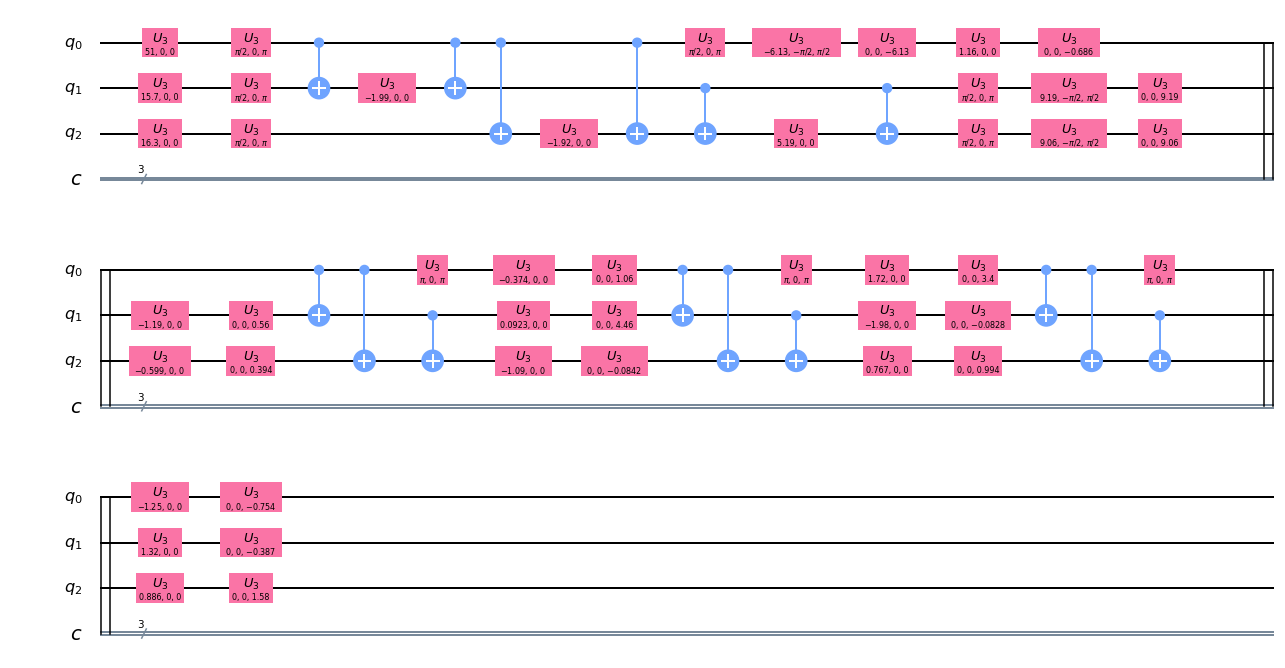

In [48]:
print("Accuracy of the model: {}".format(accuracy))
print("Circuit Cost: {}".format(circuit_cost))
print("The complete unrolled circuit: ")
%matplotlib inline
full_circuit.draw()

So yeah, from knowing nothing about Quantum Machine Learning to getting a relatively good score in the challenge, this was our journey!